In [62]:
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt

api_base_url = "http://16.16.170.3/"
# team_id = Lu2xdzj (take care to use the same team id and start game 🧑🏼‍🚒)
team_id="xxx"
total_budget=0
def init_fox(team_id):
    '''
    In this fucntion you need to hit to the endpoint to start the game as a fox with your team id.
    If a sucessful response is returned, you will recive back the message that you can break into chunkcs
      and the carrier image that you will encode the chunk in it.
    '''
    msg="hello"
    carrier_image=imread('../SteganoGAN/sample_example/encoded.png')

    return msg, carrier_image.tolist()

def generate_message_array(message, image_carrier):  
    '''
    In this function you will need to create your own startegy. That includes:
        1. How you are going to split the real message into chunkcs
        2. Include any fake chunks
        3. Decide what 3 chuncks you will send in each turn in the 3 channels & what is their entities (F,R,E)
        4. Encode each chunck in the image carrier  
    '''
    def split_string_into_two_chars(input_string):
        pairs = [input_string[i:i+2] for i in range(0, len(input_string), 2)]
        if len(input_string) % 2 != 0:
            pairs.append(pairs.pop()[0])
        return pairs
    new_message = split_string_into_two_chars(message)
    # new_message =[message]
    index=0
    channel=0
    def sent_message(fake_msg,real_msg):
        global total_budget
        global channel
        message_entities=['E' for _ in range(3)]
        messages = [image_carrier for _ in range(3)]
        for i in range(len(fake_msg)):
            print(fake_msg[i])
            image=encode(image_carrier.copy(),fake_msg[i]).tolist()
            # plt.figure()  # Adjust the figure size as needed
            # plt.imshow(image, cmap='gray', aspect='auto')
            # plt.axis('off')
            # plt.show()
            messages[channel]=image
            message_entities[channel]='F'
            channel=(channel+1)%3
            total_budget-=1
        
        for i in range(len(real_msg)):
            image=encode(image_carrier.copy(),real_msg[i]).tolist()
            print(channel)
            messages[channel]=image
            message_entities[channel]='R'
            channel=(channel+1)%3
        print("----------------------------------------")

        # send_message(team_id,messages,message_entities)
        for i in range(3):
            print(message_entities[i])
            plt.figure()  # Adjust the figure size as needed
            plt.imshow(messages[i], cmap='gray', aspect='auto')
            plt.axis('off')
            plt.show()
            
    print(new_message)
    while(total_budget>0):
        if(total_budget>=2):
            sent_message(["fake","fffffffffffffff"],[new_message[index]])
        else:
            sent_message(["fake"],[new_message[index]])
        index+=1
    while(index< len(new_message)):
        print("index",index)
        sent_message([],[new_message[index]])
        index+=1


def get_riddle(team_id, riddle_id):
    '''
    In this function you will hit the api end point that requests the type of riddle you want to solve.
    use the riddle id to request the specific riddle.
    Note that: 
        1. Once you requested a riddle you cannot request it again per game. 
        2. Each riddle has a timeout if you didnot reply with your answer it will be considered as a wrong answer.
        3. You cannot request several riddles at a time, so requesting a new riddle without answering the old one
          will allow you to answer only the new riddle and you will have no access again to the old riddle. 
    '''
    payload_sent = {
        'teamId': team_id,
        "riddleId": riddle_id
    }
    response = requests.post(api_base_url+"/fox/get-riddle", json=payload_sent)
    if response.status_code == 200 or response.status_code == 201:
        data = response.json()
        test_case = data['test_case']
    else:
        print("error: ", response.status_code)
    return test_case

def solve_riddle(team_id, solution):
    '''
    In this function you will solve the riddle that you have requested. 
    You will hit the API end point that submits your answer.
    Use te riddle_solvers.py to implement the logic of each riddle.
    '''
    payload_sent = {
        'teamId': team_id,
        "solution": solution
    }
    response = requests.post(api_base_url+"/fox/solve-riddle", json=payload_sent)
    if response.status_code == 200 or response.status_code == 201:
        data = response.json()
        budget_increase = data['budget_increase']
        total_budget = data['total_budget']
        status = data['status']
        if(status == "success"):
            print("Riddle solved successfully")
            print("Budget increased by: ", budget_increase)
            print("Total budget: ", total_budget)
        return 
    else:
        print("error: ", response.status_code)

def send_message(team_id, messages, message_entities=['F', 'E', 'R']):
    '''
    Use this function to call the api end point to send one chunk of the message. 
    You will need to send the message (images) in each of the 3 channels along with their entites.
    Refer to the API documentation to know more about what needs to be send in this api call. 
    '''
    payload_sent = {
        'teamId': team_id,
        "messages": messages,
        "message_entities":message_entities
    }
    # response = requests.post(api_base_url+"/fox/send-message", json=payload_sent)
    # if response.status_code == 200 or response.status_code == 201:
    #    print("Message sent successfully")
    # else:
    #     print("error: ", response.status_code)
   
def end_fox(team_id):
    '''
    Use this function to call the api end point of ending the fox game.
    Note that:
    1. Not calling this fucntion will cost you in the scoring function
    2. Calling it without sending all the real messages will also affect your scoring fucntion
      (Like failing to submit the entire message within the timelimit of the game).
    '''
    payload_sent = {
        'teamId': team_id,
    }
    response = requests.post(api_base_url+"/fox/end-game", json=payload_sent)
    if response.status_code == 200 or response.status_code == 201:
        data = response.json()
        print("Game ended successfully")
    else:
        print("error: ", response.status_code)
    pass

def submit_fox_attempt(team_id):
    '''
     Call this function to start playing as a fox. 
     You should submit with your own team id that was sent to you in the email.
     Remeber you have up to 15 Submissions as a Fox In phase1.
     In this function you should:
        1. Initialize the game as fox 
        2. Solve riddles 
        3. Make your own Strategy of sending the messages in the 3 channels
        4. Make your own Strategy of splitting the message into chunks
        5. Send the messages 
        6. End the Game
    Note that:
        1. You HAVE to start and end the game on your own. The time between the starting and ending the game is taken into the scoring function
        2. You can send in the 3 channels any combination of F(Fake),R(Real),E(Empty) under the conditions that
            2.a. At most one real message is sent
            2.b. You cannot send 3 E(Empty) messages, there should be atleast R(Real)/F(Fake)
        3. Refer To the documentation to know more about the API handling 
    '''
    global total_budget
    msg, carrier_image=init_fox(team_id)
    ## solve riddles
    # for riddle_id,riddle_func in riddle_solvers.items():
    #     test_case = get_riddle(team_id, riddle_id)
    #     solution = riddle_func(test_case)
    #     solve_riddle(team_id, solution)
    total_budget=3
    total_budget=min(total_budget,12)
    ## generate message array
    generate_message_array(msg, carrier_image)
    # end_fox(team_id)


submit_fox_attempt(team_id)

['he', 'll', 'o']
fake


AttributeError: 'list' object has no attribute 'shape'

In [9]:
pip install opencv-python


   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 991.0 kB/s eta 0:00:39
   ---------------------------------------- 0.2/38.6 MB 1.8 MB/s eta 0:00:21
   ---------------------------------------- 0.3/38.6 MB 2.4 MB/s eta 0:00:17
    --------------------------------------- 0.6/38.6 MB 3.5 MB/s eta 0:00:11
    --------------------------------------- 0.9/38.6 MB 4.2 MB/s eta 0:00:09
   - -------------------------------------- 1.3/38.6 MB 5.0 MB/s eta 0:00:08
   - -------------------------------------- 1.6/38.6 MB 5.2 MB/s eta 0:00:08
   - -------------------------------------- 1.8/38.6 MB 5.6 MB/s eta 0:00:07
   - -------------------------------------- 1.8/38.6 MB 5.6 MB/s eta 0:00:07
   -- ------------------------------------- 2.1/38.6 MB 4.5 MB/s eta 0:00:09
   -- ------------------------------------- 2.9/38.6 MB 6.1 MB/s eta 0:00:06
   --- ------------------------------------ 3.1/38.6 MB 5.7 MB/s eta 0:00:07
   -


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import numpy as np
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt


class SteganographyException(Exception):
    pass

class LSBSteg():
    def __init__(self, im):
        self.image = im
        self.height, self.width, self.nbchannels = im.shape
        self.size = self.width * self.height
        
        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations
        
        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)
        
        self.curwidth = 0  # Current width position
        self.curheight = 0 # Current height position
        self.curchan = 0   # Current channel position

    def put_binary_value(self, bits): #Put the bits in the image
        for c in bits:
            val = list(self.image[self.curheight,self.curwidth]) #Get the pixel value as a list
            if int(c) == 1:
                val[self.curchan] = int(val[self.curchan]) | self.maskONE #OR with maskONE
            else:
                val[self.curchan] = int(val[self.curchan]) & self.maskZERO #AND with maskZERO
            self.image[self.curheight,self.curwidth] = tuple(val)
            self.next_slot() #Move "cursor" to the next space

    def next_slot(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("No available slot remaining (image filled)")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1
            
    def next_slot2(self):
        self.curchan += 1  # Move to the next channel
        if self.curchan == self.nbchannels:  # If all channels are exhausted
            self.curchan = 0  # Reset channel to the first one
            self.curwidth += 1  # Move to the next pixel on the same line
            if self.curwidth == self.width:  # If all pixels in the row are exhausted
                self.curwidth = 0  # Reset pixel position to the beginning of the row
                self.curheight += 1  # Move to the next row
                if self.curheight == self.height:  # If all rows are exhausted
                    self.curheight = 0  # Reset row position to the beginning
                    if self.maskONE == 128:  # If the last mask is reached
                        raise SteganographyException("No available slot remaining (image filled)")
                    else:  # Use the next available mask
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)

    def read_bit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth][self.curchan]
        # why & self.maskONE
        # val = 0b1011100
        # maskONE = 0b1000000
        # val & maskONE = 0b1000000
        val = int(val) & self.maskONE
        self.next_slot()
        if val > 0:
            return "1"
        else:
            return "0"
    
    def read_byte(self):
        return self.read_bits(8)
    
    def read_bits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.read_bit()
        return bits

    def byteValue(self, val):
        return self.binary_value(val, 8)
        
        
    # test case:
    # # Expected binary value: '0110'
    # Explanation: Binary representation of 6 with bitsize 4.
    #binary_value(6, 4) == '0110'
    ###
    def binary_value(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:] ## delete 0b
        if len(binval) > bitsize:
            raise SteganographyException("binary value larger than the expected size")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    ## encode text by steps:
    # 1. put len of text
    # 2. put each char of text
    def encode_text(self, txt):
        l = len(txt)
        binl = self.binary_value(l, 16) #Length coded on 2 bytes so the text size can be up to 65536 bytes long
        self.put_binary_value(binl) #Put text length coded on 4 bytes
        for char in txt: #And put all the chars
            c = ord(char)
            self.put_binary_value(self.byteValue(c))
        return self.image

    # 1. read len of text
    # 2. read each char of text
    # 3. return the text
    def decode_text(self):
        ls = self.read_bits(16) #Read the text size in bytes
        l = int(ls,2)
        i = 0
        unhideTxt = ""
        while i < l: #Read all bytes of the text
            tmp = self.read_byte() #So one byte
            i += 1
            unhideTxt += chr(int(tmp,2)) #Every chars concatenated to str
        return unhideTxt

    def encode_image(self, imtohide):
        w = imtohide.width
        h = imtohide.height
        if self.width*self.height*self.nbchannels < w*h*imtohide.channels:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        binw = self.binary_value(w, 16) #Width coded on to byte so width up to 65536
        binh = self.binary_value(h, 16)
        self.put_binary_value(binw) #Put width
        self.put_binary_value(binh) #Put height
        for h in range(imtohide.height): #Iterate the hole image to put every pixel values
            for w in range(imtohide.width):
                for chan in range(imtohide.channels):
                    val = imtohide[h,w][chan]
                    self.put_binary_value(self.byteValue(int(val)))
        return self.image

                    
    def decode_image(self):
        width = int(self.read_bits(16),2) #Read 16bits and convert it in int
        height = int(self.read_bits(16),2)
        unhideimg = np.zeros((width,height, 3), np.uint8) #Create an image in which we will put all the pixels read
        for h in range(height):
            for w in range(width):
                for chan in range(unhideimg.channels):
                    val = list(unhideimg[h,w])
                    val[chan] = int(self.read_byte(),2) #Read the value
                    unhideimg[h,w] = tuple(val)
        return unhideimg
    
    def encode_binary(self, data):
        l = len(data)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.put_binary_value(self.binary_value(l, 64))
        for byte in data:
            byte = byte if isinstance(byte, int) else ord(byte) # Compat py2/py3
            self.put_binary_value(self.byteValue(byte))
        return self.image

    def decode_binary(self):
        l = int(self.read_bits(64), 2)
        output = b""
        for i in range(l):
            output += chr(int(self.read_byte(),2)).encode("utf-8")
        return output

def encode(image: np.ndarray, message: str) -> np.array:
    # steg = LSBSteg(cv2.imread(filepath))
    steg = LSBSteg(image)
    img_encoded = steg.encode_text(message)
    return img_encoded

def decode(encoded: np.array) -> str:
    steg = LSBSteg(encoded)
    return steg.decode_text()



encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode
encode


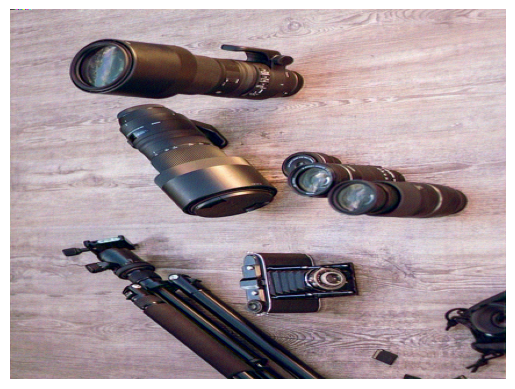

In [34]:
image = imread('../SteganoGAN/sample_example/encoded.png')
# # # Convert the image to a NumPy array
# image_array = np.array(image)
# print(decode(image_array))
# l=LSBSteg(image)
imag=encode(image,"hello")
# import matplotlib.pyplot as plt
plt.figure()  # Adjust the figure size as needed
plt.imshow(imag, cmap='gray', aspect='auto')
plt.axis('off')
plt.show()
# l.curchan=0
# l.curheight=0
# l.curwidth=0
# print(l.decode_text())
